<a href="https://colab.research.google.com/github/swaroopkasaraneni/DatasciencePython/blob/main/Supervisor1Case3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
Fields in Data
•credit.policy: 1 if the customer meets the credit underwriting criteria of PeerLoanKart, and 0 otherwise
•purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other")•int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by PeerLoanKart to be riskierare assigned higher interest rates
•installment: The monthly installments owed by the borrower if the loan is funded
•log.annual.inc: The natural log of the self-reported annual incomeof the borrower
•dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income)
•fico: The FICO credit score of the borrower
•days.with.cr.line: The number of days the borrower has had a credit line
•revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle)
•revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available)
•inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months
•delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years
•pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments)
•not.fully.paid: This is the output field. Please note that 1 means the borrower is not going to pay the loan completely
```


Increase in profits up to 20% as NPA will be reduced due to loan disbursal for only good borrowers

Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1611
           1       0.53      0.03      0.05       305

    accuracy                           0.84      1916
   macro avg       0.69      0.51      0.48      1916
weighted avg       0.79      0.84      0.78      1916



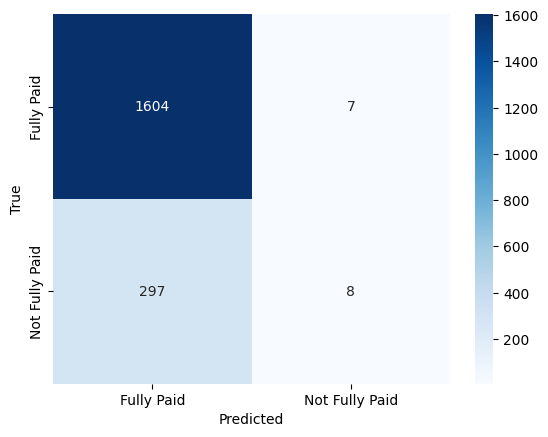

ROC-AUC Score: 0.66


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('/content/loan_borowwer_data.csv')

df.isnull().sum()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

df = pd.get_dummies(df, columns=['purpose'], drop_first=True)

# Scaling numeric features
scaler = StandardScaler()
df[['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util']] = scaler.fit_transform(
    df[['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util']])

X = df.drop(columns=['not.fully.paid'])
y = df['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fully Paid', 'Not Fully Paid'], yticklabels=['Fully Paid', 'Not Fully Paid'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f'ROC-AUC Score: {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]):.2f}')





In [4]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [13]:
# Keep only columns that were used for training
X_test = X_test[X_train.columns]

# Predict probabilities of repayment
y_prob = rf.predict_proba(X_test)[:, 1]


# Filter out high-risk borrowers
high_risk_borrowers = X_test[y_prob < 0.5]

# Classify borrowers into risk categories
X_test['repayment_probability'] = y_prob
X_test['loan_approval'] = X_test['repayment_probability'].apply(lambda x: 'Approve' if x >= 0.6 else 'Deny')

# Simulate profit impact
approved_loans = X_test[X_test['loan_approval'] == 'Approve']
denied_loans = X_test[X_test['loan_approval'] == 'Deny']

approved_loans

<ipython-input-13-917829725161>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['repayment_probability'] = y_prob


,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,repayment_probability,loan_approval
8109,0,1.328335,-0.156280,-0.672506,1.400910,-1.681558,-0.048369,-0.492912,1.557954,6,0,1,False,True,False,False,False,False,0.63,Approve
7965,0,1.376760,0.821985,0.244031,1.354423,-1.418182,0.588463,-0.493564,-0.361882,6,1,0,False,False,False,False,False,True,0.61,Approve
